# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import imageio # To imread and imresize
import datetime
from PIL import Image, ImageFilter, ImageEnhance # To imread and imresize
import matplotlib.pyplot as plt
import pathlib
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from keras.applications.vgg16 import VGG16
from keras.applications import mobilenet
from keras.applications import resnet
import cv2
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

We set the random seed so that the results don't vary drastically.

In [3]:
! ls '/kaggle/input/gesture-recognition'

LICENSE  README.md  train  train.csv  val  val.csv


In [4]:
data_path= pathlib.Path('/kaggle/input/gesture-recognition/')

In [5]:
image_count_train = len(list(data_path.glob('train/*/*.png')))
print(image_count_train)
image_count_val = len(list(data_path.glob('val/*/*.png')))
print(image_count_val)


19890
3000


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [28]:
train_doc, val_doc = get_data('/kaggle/input/gesture-recognition/', ablation=None)
batch_size = 64 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(5,27,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [31]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmention = False, debug=False):
    # print('\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 2) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = cv2.resize(image, (120,120))

                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
#                         elif aug_type == 3: # sharpening image
#                             resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
#                         elif aug_type == 4: # Brightness enhancement
#                             resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # plotting rezised images for debugging purpose only
                    
                    shifted = cv2.warpAffine(resized_im, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),                                         (image.shape[1], image.shape[0]))
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    cropped=shifted[x0:x1,y0:y1,:]
                    image_resized=cv2.resize(cropped,(120,120))
                    batch_data[folder,idx,:,:,0] = image_resized[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_resized[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_resized[:,:,2]/255 #normalise and feed in the image
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im.astype('uint8'))
                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/kaggle/input/gesture-recognition/train'
val_path = '/kaggle/input/gesture-recognition/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


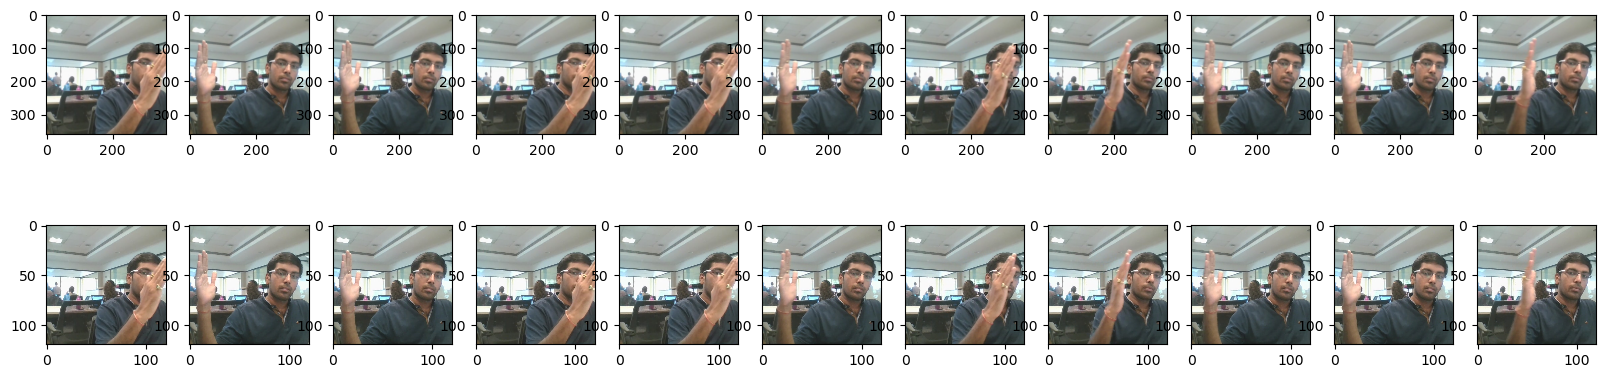

In [32]:
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [34]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU,SimpleRNN, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [35]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = False)
val_generator = generator(val_path, val_doc, batch_size)

## Other Models Tried

In [ ]:
# model = Sequential()
# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

In [43]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(5, activation='softmax'))

In [ ]:
#  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
# a = base_model.output
# a = Flatten()(a)
# features = Dense(64, activation='relu')(a)
# conv_model = Model(inputs=base_model.input, outputs=features)

# for layer in base_model.layers:
#     layer.trainable = False

# model = Sequential()
# model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
# model.add(GRU(128, return_sequences=True))
# model.add(GRU(64))
# model.add(Dropout(dropout))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(5, activation='softmax'))

In [ ]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

In [ ]:
#  model = Sequential()
# model.add(TimeDistributed(conv_model, input_shape=input_shape))
# model.add(GRU(128, return_sequences=True))
# model.add(GRU(64))
# model.add(Dropout(dropout))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(5, activation='softmax'))

In [ ]:
# model = Sequential()
# model.add(TimeDistributed(mobilenet_transfer,input_shape=(x,y,z,3)))

# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Flatten()))

# model.add(GRU(128))
# model.add(Dropout(dropout))

# model.add(Dense(128,activation='relu'))
# model.add(Dropout(dropout))

# model.add(Dense(5, activation='softmax'))

In [ ]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Conv2D(16, (3,3), activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(
#     ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Dense(64, activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(5, activation='softmax'))

## Final Model

In [37]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(len(seq_idx),120,120,3)))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.25))
model.add(GRU(128))
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))


model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [38]:
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 11, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 11, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 11, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 11, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 11, 128)          

In [39]:
model_name = 'model_init9' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [40]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [41]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.0296 - categorical_accuracy: 0.5739
Epoch 1: saving model to model_init9_2023-08-0808_54_46.488886/model-00001-1.02959-0.57386-0.46982-0.88281.h5
11/11 [==============================] - 71s 6s/step - loss: 1.0296 - categorical_accuracy: 0.5739 - val_loss: 0.4698 - val_categorical_accuracy: 0.8828 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.3117 - categorical_accuracy: 0.8381
Epoch 2: saving model to model_init9_2023-08-0808_54_46.488886/model-00002-0.31167-0.83807-1.37392-0.26562.h5
11/11 [==============================] - 56s 5s/step - loss: 0.3117 - categorical_accuracy: 0.8381 - val_loss: 1.3739 - val_categorical_accuracy: 0.2656 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.1664 - categorical_accuracy: 0.8920
Epoch 3: saving model to model_init9_2023-08-0808_54_46.488886/model-00003-0.16643-0.89205-1.00959-0.60938.h5
11/11 [=============

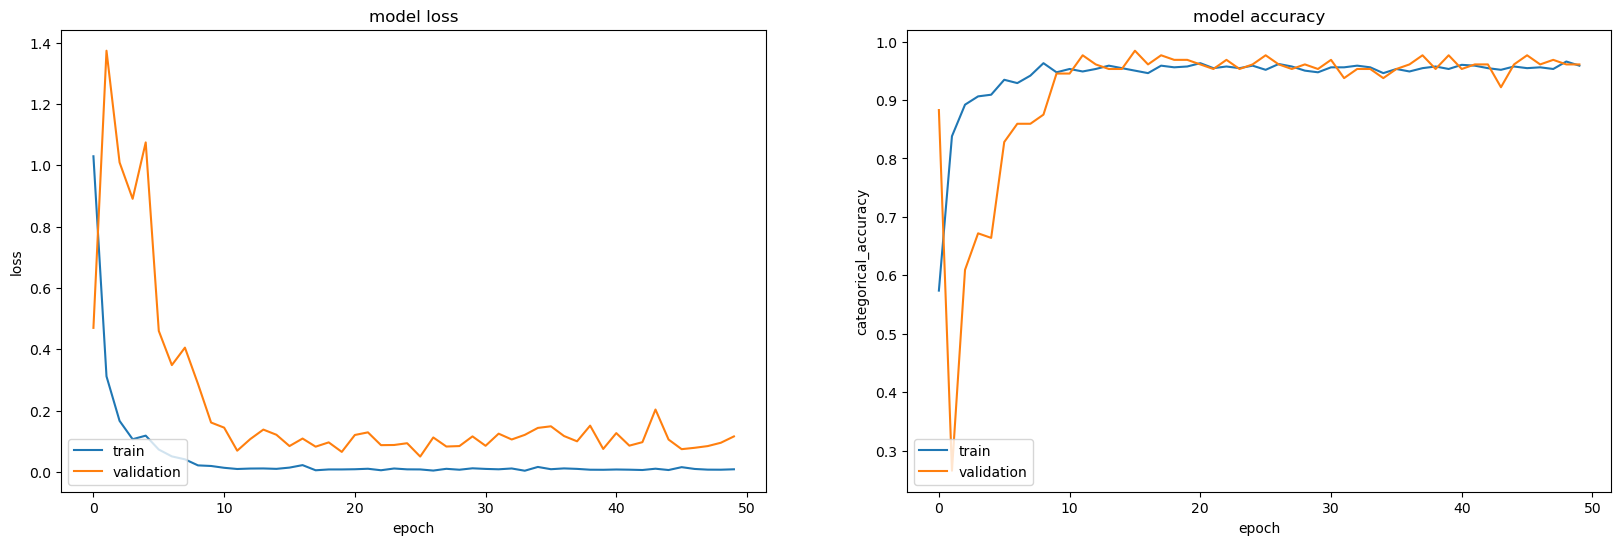

In [42]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Observation

Training Accuracy: 95.45

Validation Accuracy: 97.66

Train Loss: 0.0154

Val Loss: 0.0741
